In [1]:
! pip install neural_structured_learning

     |████████████████████████████████| 104 kB 2.8 MB/s eta 0:00:01


In [2]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import neural_structured_learning as nsl

from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

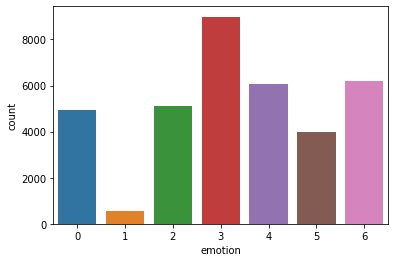

In [7]:
sns.countplot(df.emotion)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral and we are also intersted in these three classes only.`

In [8]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

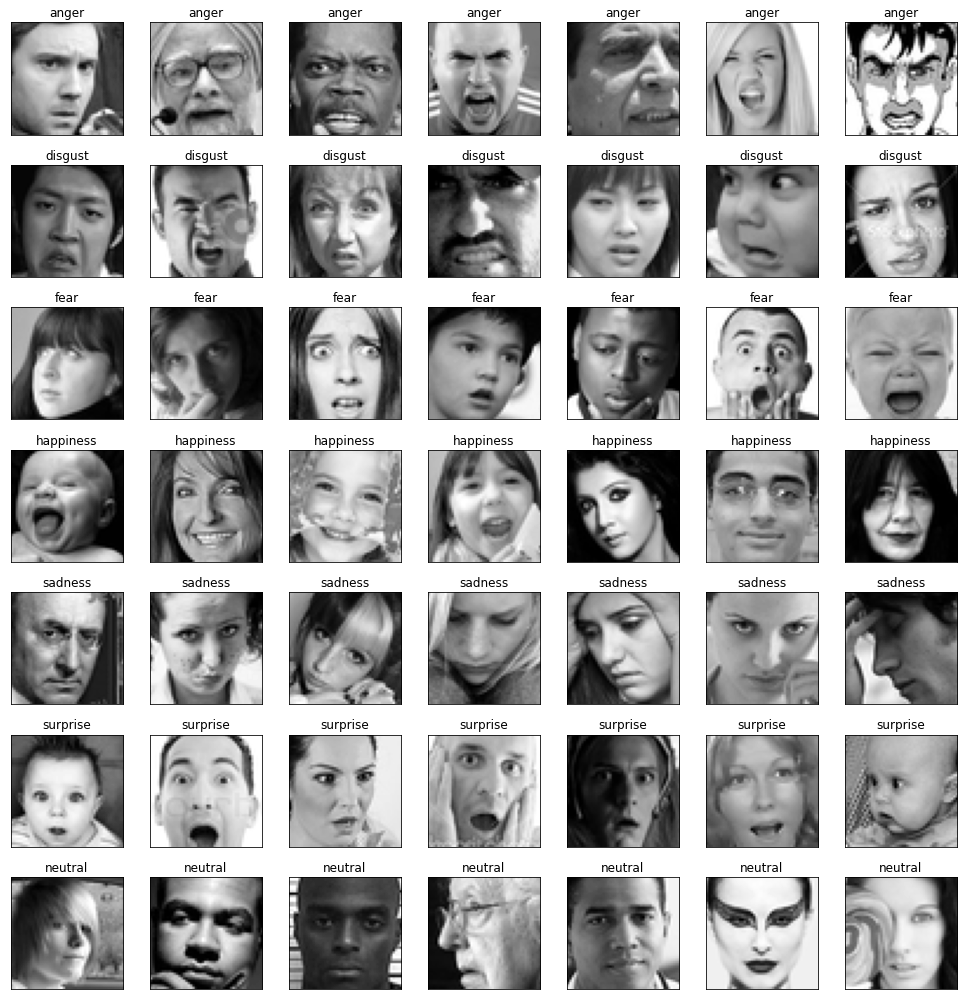

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [10]:
INTERESTED_LABELS = [3, 4, 6]

In [11]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

`Now I will make the data compatible for neural networks.`

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [13]:
img_array.shape

(21264, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [15]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


`Splitting the data into training and validation set.`

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [17]:
del df
del img_array
del img_labels

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = 3

In [19]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [20]:
IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

In [21]:
def build_net(show_summary=True):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name=IMAGE_INPUT_NAME
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_summary:
        net.summary()
    
    return net

In [22]:
def convert_to_dict_generator(image_data_gen):
    for image, label in image_data_gen:
        yield {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label} 

I tried many different configurations of `multiplier` and `adv_step_size` and found below configurations as the best. You can see the results of all my runs [here](https://app.wandb.ai/gauravsharma/NSL?workspace=user-gauravsharma).

In [37]:
base_model = build_net(show_summary=False)

# tune adv_step in range [0.01, 0.1] & multiplier in range [0.1, 0.4]
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.3, adv_step_size=0.01)
adv_model = nsl.keras.AdversarialRegularization(base_model, adv_config=adv_config)

In [38]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.25,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    lr_scheduler,
]

batch_size = 32
epochs = 25

In [39]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [40]:
adv_model.compile(
    optimizer=optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# This is a hack to fix the error for tf-2.1, this is instructed by the tf community itself.
# You can read the issue thread for this, https://github.com/tensorflow/neural-structured-learning/issues/52
adv_model.evaluate({IMAGE_INPUT_NAME: X_valid[:10], LABEL_INPUT_NAME: y_valid[:10]})

history = adv_model.fit_generator(
    convert_to_dict_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size)),
    validation_data=tf.data.Dataset.from_tensor_slices({IMAGE_INPUT_NAME: X_valid, LABEL_INPUT_NAME: y_valid}).batch(batch_size),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True,
)

10/10 [==============================] - 1s 72ms/sample - loss: 4.0015 - categorical_crossentropy: 3.0682 - categorical_accuracy: 0.3000 - adversarial_loss: 3.1109
Train for 598.03125 steps, validate for 67 steps
Epoch 1/25
599/598 [==============================] - 24s 41ms/step - loss: 1.6445 - categorical_crossentropy: 1.2627 - categorical_accuracy: 0.4110 - adversarial_loss: 1.2724 - val_loss: 1.2792 - val_categorical_crossentropy: 0.9831 - val_categorical_accuracy: 0.4979 - val_adversarial_loss: 0.9868
Epoch 2/25
599/598 [==============================] - 19s 32ms/step - loss: 1.2817 - categorical_crossentropy: 0.9844 - categorical_accuracy: 0.5129 - adversarial_loss: 0.9910 - val_loss: 1.2299 - val_categorical_crossentropy: 0.9426 - val_categorical_accuracy: 0.5529 - val_adversarial_loss: 0.9575
Epoch 3/25
599/598 [==============================] - 19s 32ms/step - loss: 1.1304 - categorical_crossentropy: 0.8668 - categorical_accuracy: 0.5914 - adversarial_loss: 0.8785 - val_loss:

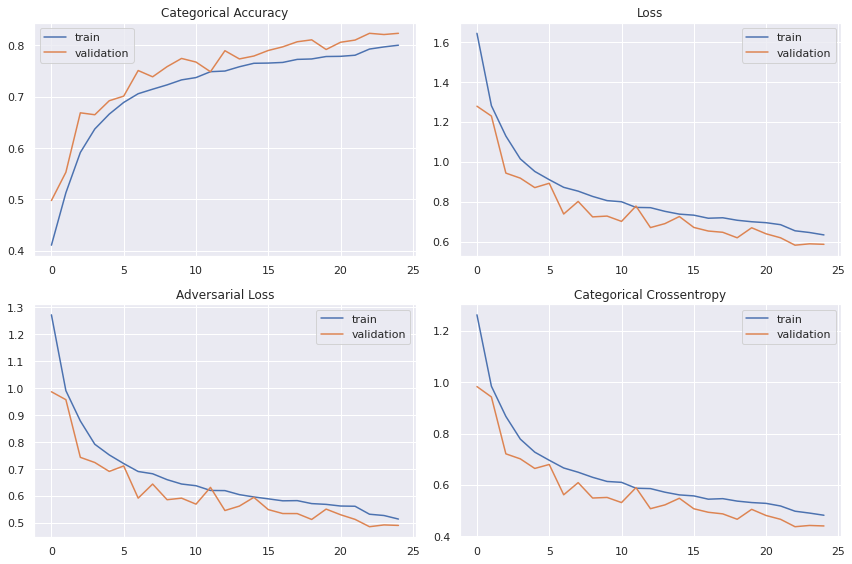

In [41]:
sns.set()
fig = pyplot.figure(0, (12, 8))

ax = pyplot.subplot(2, 2, 1)
sns.lineplot(history.epoch, history.history['categorical_accuracy'], label="train")
sns.lineplot(history.epoch, history.history['val_categorical_accuracy'], label="validation")
pyplot.title('Categorical Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(2, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label="train")
sns.lineplot(history.epoch, history.history['val_loss'], label="validation")
pyplot.title('Loss')
pyplot.tight_layout()

ax = pyplot.subplot(2, 2, 3)
sns.lineplot(history.epoch, history.history['adversarial_loss'], label="train")
sns.lineplot(history.epoch, history.history['val_adversarial_loss'], label="validation")
pyplot.title('Adversarial Loss')
pyplot.tight_layout()

ax = pyplot.subplot(2, 2, 4)
sns.lineplot(history.epoch, history.history['categorical_crossentropy'], label="train")
sns.lineplot(history.epoch, history.history['val_categorical_crossentropy'], label="validation")
pyplot.title('Categorical Crossentropy')
pyplot.tight_layout()

pyplot.show()

`Maybe model is underfitting for now.`

In [42]:
adv_model.evaluate(
    {IMAGE_INPUT_NAME: X_valid, LABEL_INPUT_NAME: y_valid}
)

2127/2127 [==============================] - 1s 580us/sample - loss: 0.5895 - categorical_crossentropy: 0.4398 - categorical_accuracy: 0.8232 - adversarial_loss: 0.4908


[0.5895360582974465, 0.43978888, 0.8232252, 0.4908493]

In [43]:
adv_model.evaluate(
    {IMAGE_INPUT_NAME: X_train, LABEL_INPUT_NAME: y_train}
)

19137/19137 [==============================] - 11s 567us/sample - loss: 0.5036 - categorical_crossentropy: 0.3760 - categorical_accuracy: 0.8460 - adversarial_loss: 0.4225


[0.5035793666586819, 0.37601316, 0.84595287, 0.42251566]

In [44]:
adv_model.save_weights("adv_model_weights.h5")
base_model.save("adv_base_model.h5")

total wrong validation predictions: 376
accuracy: 82.32300000000001%


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       899
           1       0.81      0.70      0.75       608
           2       0.71      0.81      0.76       620

    accuracy                           0.82      2127
   macro avg       0.81      0.81      0.81      2127
weighted avg       0.83      0.82      0.82      2127



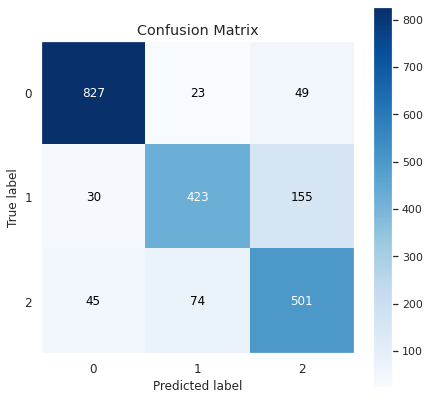

In [45]:
yhat_valid = base_model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}')
print(f"accuracy: {round(np.sum(np.argmax(y_valid, axis=1) == yhat_valid)/len(y_valid),5)*100}%\n\n")
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [46]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

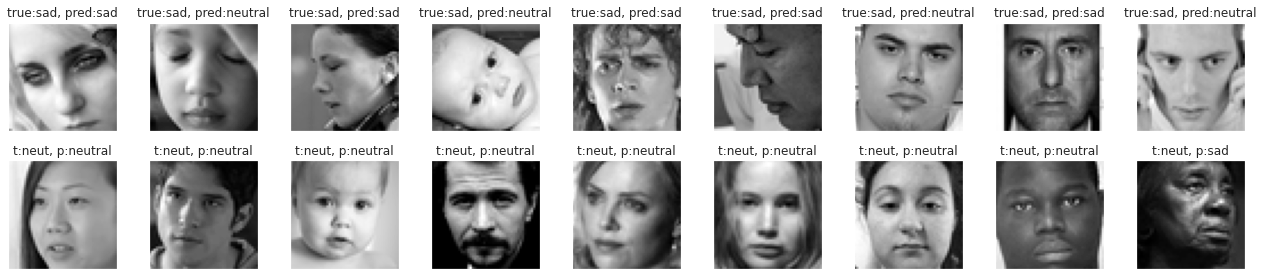

In [47]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[base_model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[base_model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

See in the first row 7th and 8th images looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.